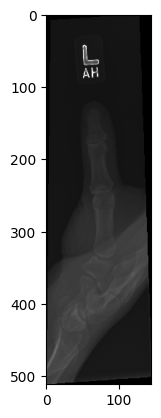

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
image_path = r"C:\Users\Vivo\2025_medicalimage_and_AI\MURA-v1.1"
# load and visualize the image
img = Image.open(f"{image_path}"+"/train/XR_FINGER/patient00169/study1_negative/image1.png").convert("L")
plt.imshow(img, cmap='gray')
plt.show()

In [2]:
# get the label of the image (show details)
import pandas as pd
meta = pd.read_csv(f"{image_path}"+"\\train_labeled_studies.csv",header=None, names=['path','label'])
meta.head()

,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [7]:
# get the label of the image (show details)
from pathlib import Path
import pandas as pd

base_dir = Path("MURA-v1.1/train/XR_SHOULDER")
study_paths = list(base_dir.glob("patient*/study*_*/"))

data = []
for study_path in study_paths:
    label = 1 if "positive" in study_path.name else 0
    data.append({"path": str(study_path), "label": label})

meta = pd.DataFrame(data)
meta.head()


""


In [ ]:

# show the label of the image
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

meta = pd.read_csv("/content/drive/MyDrive/MURA-v1.1/train_labeled_studies.csv",header=None, 
                   names=['path','label'])
for idx, row in meta.iterrows():
    img = Image.open("train/XR_FINGER/patient00169/study1_negative/image1.png").convert("L")
    label = row['label']
    plt.imshow(img, cmap='gray')
    plt.title(f"Label {label}")
    plt.show()
    break

In [ ]:
# loading data using PyTorch (file)
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder("train", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print(dataset.classes)
# ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
print(dataset.class_to_idx)
# {'XR_ELBOW': 0, 'XR_FINGER': 1, 'XR_FOREARM': 2, 'XR_HAND': 3, 'XR_HUMERUS': 4, 'XR_SHOULDER': 5, 'XR_WRIST': 6}

In [ ]:
# loading data using PyTorch (folder)
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from glob import glob
from torch.utils.data import DataLoader

class MuraDataset(Dataset):
    def __init__(self, csv_path, data_path, transform=None):
        self.data = pd.read_csv(csv_path, header=None, names=['path', 'label'])
        self.data_path = data_path
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        study_folder = os.path.join(self.data_path, self.data.iloc[index]['path'])
        label = self.data.iloc[index]['label']
        image_paths = glob(os.path.join(study_folder, '*.png'))
        images = []
        for img_path in image_paths:
            img = Image.open(img_path).convert('L') 
            if self.transform:
                img = self.transform(img)
            images.append(img)

        images = torch.stack(images)
        label = torch.tensor(label, dtype=torch.long)

        return images, label

    def __len__(self):
        return len(self.data)

def mura_collate_fn(batch):
    image_stacks = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return image_stacks, labels
    
from torch.utils.data import DataLoader

valid_dataset = MuraDataset(
    csv_path="/content/drive/MyDrive/MURA-v1.1/valid_labeled_studies.csv",
    data_path="/content/drive/MyDrive/"
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=mura_collate_fn
)
## Show first batch
import numpy as np
import matplotlib.pyplot as plt

for image_stacks, labels in valid_loader:
  for i in range(len(image_stacks)):
    image = image_stacks[i][0]
    image_np = image.numpy()
    if image_np.shape[0] == 1:
        image_np = image_np.squeeze(0)
    elif image_np.shape[0] == 1:
      image_np = np.transpose(image_np, (1,2,0))
    else:
      print("Unexpected image shape")

    plt.imshow(image_np, cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.show()
  break
